# SPINN NF2
> NF2 + SPINN

## Input data

In [ ]:
from zpinn.lowloumag import LowLouMag

In [ ]:
b = LowLouMag(resolutions=[32, 32, 32])
b.calculate()

UniformGrid (0x7f36df9be020)
  N Cells:      29791
  N Points:     32768
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   32, 32, 32
  Spacing:      6.452e-02, 6.452e-02, 6.452e-02
  N Arrays:     3

In [ ]:
import numpy as np

In [ ]:
Nx, Ny, _ =  b.grid.dimensions
bottom_subset = (0, Nx-1, 0, Ny-1, 0, 0)
bottom = b.grid.extract_subset(bottom_subset).extract_surface()
b_bottom = bottom['B'].reshape(Nx, Ny, 3)
b_bottom = np.array(b_bottom)

In [ ]:
b_bottom.shape

(32, 32, 3)

In [ ]:
import matplotlib.pyplot as plt

<matplotlib.image.AxesImage>

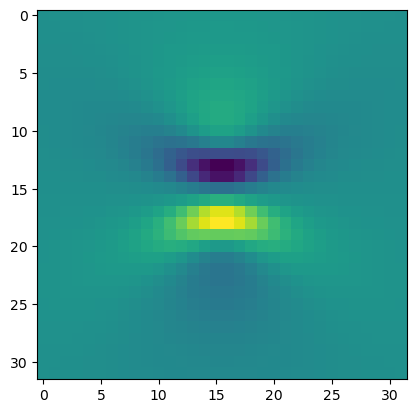

In [ ]:
plt.imshow(b_bottom[:, :, 0])

# Model

In [ ]:
import jax 
import jax.numpy as jnp
from jax import jvp
import optax
from flax import linen as nn 

from typing import Sequence
from functools import partial

import time
from tqdm import trange

In [ ]:
def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out
    
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

In [ ]:
class SPINN3d(nn.Module):
    features: Sequence[int]
    r: int
    out_dim: int
    pos_enc: int
    mlp: str

    @nn.compact
    def __call__(self, x, y, z):
        '''
        inputs: input factorized coordinates
        outputs: feature output of each body network
        xy: intermediate tensor for feature merge btw. x and y axis
        pred: final model prediction (e.g. for 2d output, pred=[u, v])
        '''
        if self.pos_enc != 0:
            # positional encoding only to spatial coordinates
            freq = jnp.expand_dims(jnp.arange(1, self.pos_enc+1, 1), 0)
            y = jnp.concatenate((jnp.ones((y.shape[0], 1)), jnp.sin(y@freq), jnp.cos(y@freq)), 1)
            z = jnp.concatenate((jnp.ones((z.shape[0], 1)), jnp.sin(z@freq), jnp.cos(z@freq)), 1)

            # causal PINN version (also on time axis)
            #  freq_x = jnp.expand_dims(jnp.power(10.0, jnp.arange(0, 3)), 0)
            # x = x@freq_x
            
        inputs, outputs, xy, pred = [x, y, z], [], [], []
        init = nn.initializers.glorot_normal()

        if self.mlp == 'mlp':
            for X in inputs:
                for fs in self.features[:-1]:
                    X = nn.Dense(fs, kernel_init=init)(X)
                    X = nn.activation.tanh(X)
                X = nn.Dense(self.r*self.out_dim, kernel_init=init)(X)
                outputs += [jnp.transpose(X, (1, 0))]

        elif self.mlp == 'modified_mlp':
            for X in inputs:
                U = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
                V = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
                H = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
                for fs in self.features[:-1]:
                    Z = nn.Dense(fs, kernel_init=init)(H)
                    Z = nn.activation.tanh(Z)
                    H = (jnp.ones_like(Z)-Z)*U + Z*V
                H = nn.Dense(self.r*self.out_dim, kernel_init=init)(H)
                outputs += [jnp.transpose(H, (1, 0))]
        
        for i in range(self.out_dim):
            xy += [jnp.einsum('fx, fy->fxy', outputs[0][self.r*i:self.r*(i+1)], outputs[1][self.r*i:self.r*(i+1)])]
            pred += [jnp.einsum('fxy, fz->xyz', xy[i], outputs[-1][self.r*i:self.r*(i+1)])]

        if len(pred) == 1:
            # 1-dimensional output
            return pred[0]
        else:
            # n-dimensional output
            return pred

In [ ]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

In [ ]:
nc = 32 # number of collocation points

features = 256 # feature size of each layer
n_layers = 8 # the number of layer
feat_sizes = tuple([features for _ in range(n_layers)]) # feature sizes
r = 128 # rank of a approximated tensor
out_dim = 3 # size of model output

lr = 1e-3 # learning rate
epochs = 1000
log_iter = 100

# Loss weight
# lbda_c = 100
# lbda_ic = 10

In [ ]:
@partial(jax.jit, static_argnums=(0,))
def generate_train_data(nc, key):
    keys = jax.random.split(key, 4)
    
    # collocation points
    xc = jax.random.uniform(keys[1], (nc, 1), minval=0., maxval=2.)
    yc = jax.random.uniform(keys[2], (nc, 1), minval=0., maxval=2.)
    zc = jax.random.uniform(keys[3], (nc, 1), minval=0., maxval=2.)

    # # boundary points
    xb = [xc, 
          xc, 
          jnp.array([[0.]]), 
          jnp.array([[2.]]), 
          xc, 
          xc]
    yb = [yc, 
          yc, 
          yc, 
          yc, 
          jnp.array([[0.]]), 
          jnp.array([[2.]])]
    zb = [jnp.array([[0.]]), 
          jnp.array([[2.]]), 
          zc, 
          zc, 
          zc, 
          zc]

    return xc, yc, zc, xb, yb, zb

In [ ]:
def curlx(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_x = uz_y - uy_z
    vec_z = jnp.ones(z.shape)
    vec_y = jnp.ones(y.shape)
    uy_z = jvp(lambda z: apply_fn(params, x, y, z)[1], (z,), (vec_z,))[1]
    uz_y = jvp(lambda y: apply_fn(params, x, y, z)[2], (y,), (vec_y,))[1]
    wx = uz_y - uy_z
    return wx


def curly(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_y = ux_z - uz_x
    vec_z = jnp.ones(z.shape)
    vec_x = jnp.ones(x.shape)
    ux_z = jvp(lambda z: apply_fn(params, x, y, z)[0], (z,), (vec_z,))[1]
    uz_x = jvp(lambda x: apply_fn(params, x, y, z)[2], (x,), (vec_x,))[1]
    wy = ux_z - uz_x
    return wy

def curlz(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_z = uy_x - ux_y
    vec_y = jnp.ones(y.shape)
    vec_x = jnp.ones(x.shape)
    ux_y = jvp(lambda y: apply_fn(params, x, y, z)[0], (y,), (vec_y,))[1]
    uy_x = jvp(lambda x: apply_fn(params, x, y, z)[1], (x,), (vec_x,))[1]
    wz = uy_x - ux_y
    return wz


In [ ]:
@partial(jax.jit, static_argnums=(0,))
def apply_model_spinn(apply_fn, params, *train_data):
    def residual_loss(params, x, y, z):
        # calculate u
        Bx, By, Bz = apply_fn(params, x, y, z)
        B = jnp.stack([Bx, By, Bz], axis=-1)
        
        # calculate J
        Jx = curlx(apply_fn, params, x, y, z)
        Jy = curly(apply_fn, params, x, y, z)
        Jz = curlz(apply_fn, params, x, y, z)
        J = jnp.stack([Jx, Jy, Jz], axis=-1)

        JxB = jnp.cross(J, B, axis=-1)

        loss_ff = jnp.mean(JxB**2)

        # tangent vector dx/dx
        # assumes x, y, z have same shape (very important)
        vec = jnp.ones(x.shape)
        
        Bx_x = jvp(lambda x: apply_fn(params, x, y, z)[0], (x,), (vec,))[1]
        # Bx_y = jvp(lambda y: apply_fn(params, x, y, z)[0], (y,), (vec,))[1]
        # Bx_z = jvp(lambda z: apply_fn(params, x, y, z)[0], (z,), (vec,))[1]

        # By_x = jvp(lambda x: apply_fn(params, x, y, z)[1], (x,), (vec,))[1]
        By_y = jvp(lambda y: apply_fn(params, x, y, z)[1], (y,), (vec,))[1]
        # By_z = jvp(lambda z: apply_fn(params, x, y, z)[1], (z,), (vec,))[1]

        # Bz_x = jvp(lambda x: apply_fn(params, x, y, z)[2], (x,), (vec,))[1]
        # Bz_y = jvp(lambda y: apply_fn(params, x, y, z)[2], (y,), (vec,))[1]
        Bz_z = jvp(lambda z: apply_fn(params, x, y, z)[2], (z,), (vec,))[1]

        divB = Bx_x + By_y + Bz_z
        
        loss_div = jnp.mean(divB**2)

        loss = loss_ff + loss_div

        return loss

    def boundary_loss(params, x, y, z):
        
        # loss = 0.
        # for i in np.arange(4):
        #     boundary_data_batched = boundary_batches[i, :, :, :]
        #     xb = boundary_data_batched[:, 0, :][:, 0].reshape(-1, 1)
        #     yb = boundary_data_batched[:, 0, :][:, 1].reshape(-1, 1)
        #     zb = boundary_data_batched[:, 0, :][:, 2].reshape(-1, 1)

        #     Bx, By, Bz = apply_fn(params, xb, yb, zb)
        #     # Bx, By, Bz = Bx.reshape(-1, 1), By.reshape(-1, 1), Bz.reshape(-1, 1)

        #     Bxb = boundary_data_batched[:, 1, :][:, 0].reshape(-1, 1)
        #     Byb = boundary_data_batched[:, 1, :][:, 1].reshape(-1, 1)
        #     Bzb = boundary_data_batched[:, 1, :][:, 2].reshape(-1, 1)

        #     Bxb_mesh, Byb_mesh, Bzb_mesh = jnp.meshgrid(Bxb.ravel(), Byb.ravel(), Bzb.ravel(), indexing='ij')
            
        #     loss += jnp.mean((Bx - Bxb_mesh)**2) + jnp.mean((By - Byb_mesh)**2) + jnp.mean((Bz - Bzb_mesh)**2)

        loss = 0.
        Bx, By, Bz = apply_fn(params,  x[0], y[0], z[0])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += jnp.mean((Bx - b_bottom[:, :, 0])**2) + jnp.mean((By - b_bottom[:, :, 1])**2) + jnp.mean((Bz - b_bottom[:, :, 2])**2)

        for i in np.arange(1, 6):
            Bx, By, Bz = apply_fn(params,  x[i], y[i], z[i])
            loss += jnp.mean((Bx)**2) + jnp.mean((By)**2) + jnp.mean((Bz)**2)
        
        return loss

    # unpack data
    xc, yc, zc, xb, yb, zb = train_data

    # isolate loss func from redundant arguments
    loss_fn = lambda params: residual_loss(params, xc, yc, zc) + boundary_loss(params, xb, yb, zb)

    loss, gradient = jax.value_and_grad(loss_fn)(params)

    return loss, gradient

In [ ]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=0, mlp='mlp')
params = model.init(
            subkey,
            jnp.ones((nc, 1)),
            jnp.ones((nc, 1)),
            jnp.ones((nc, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [ ]:
train_data = generate_train_data(nc, subkey)

In [ ]:
loss, gradient = apply_model_spinn(apply_fn, params, *train_data)
params, state = update_model(optim, gradient, params, state)

Traced<ShapedArray(float32[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x7f367c700360; to 'JaxprTracer'>], out_avals=[ShapedArray(float32[])], primitive=squeeze, params={'dimensions': (0,)}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object>, name_stack=NameStack(stack=(Transform(name='jvp'),)))) -2.1084200215587945


In [ ]:
for e in trange(1, epochs + 1):
    start = time.time()

    if e % 100 == 0:
        # sample new input data
        key, subkey = jax.random.split(key, 2)
        train_data = generate_train_data(nc, subkey)

    loss, gradient = apply_model_spinn(apply_fn, params, *train_data)
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

 11%|█         | 106/1000 [00:02<00:21, 40.92it/s]

Epoch: 100/1000 --> total loss: 2051.15185547


 21%|██        | 207/1000 [00:05<00:21, 37.15it/s]

Epoch: 200/1000 --> total loss: 2091.73168945


 31%|███       | 307/1000 [00:08<00:19, 35.63it/s]

Epoch: 300/1000 --> total loss: 2043.79211426


 39%|███▉      | 390/1000 [00:10<00:18, 32.64it/s]

In [ ]:
xx = jnp.linspace(0, 1, 32).reshape(-1, 1)
yy = jnp.linspace(0, 1, 32).reshape(-1, 1)
zz = jnp.linspace(0, 1, 32).reshape(-1, 1)
Bxx, Byy, Bzz = apply_fn(params, xx, yy, zz)

<matplotlib.image.AxesImage>

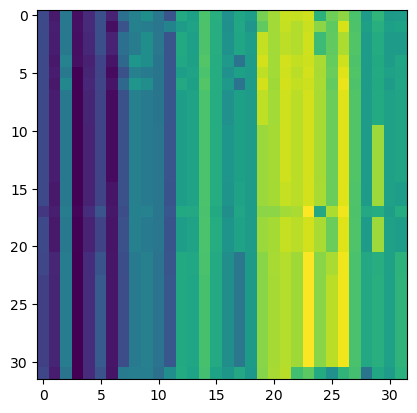

In [ ]:
plt.imshow(Bzz[:, :, 30])